In [1]:
import os
import pydicom
from PIL import Image
import numpy as np
import tensorflow as tf
import logging
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

logging.basicConfig(level=logging.INFO)


In [2]:
def load_dicom_image(path, img_size=256, use_rgb=False):
    try:
        dicom = pydicom.dcmread(path)
        image = dicom.pixel_array
        image = Image.fromarray(image)
        image = image.resize((img_size, img_size))
        image = np.array(image) / 255.0  # Normalize the image
        return tf.convert_to_tensor(image, dtype=tf.float32)
    except Exception as e:
        logging.error(f"Failed to process image {path}: {e}")
        return None


In [3]:
def process_patient_images(patient_folder, img_size=256):
    images = []
    try:
        for filename in os.listdir(patient_folder):
            if filename.endswith('.dcm'):
                path = os.path.join(patient_folder, filename)
                image = load_dicom_image(path, img_size=img_size)
                if image is not None:
                    images.append(image)
    except Exception as e:
        logging.warning(f"Error processing folder {patient_folder}: {e}")
    return images

In [4]:
import os

def collect_images_and_labels(root_dir, img_size=256):
    all_images = []
    all_labels = []
    conditions = {'cancer': 1, 'non_cancer': 0}  # Update as per your folder names

    def process_directory(directory, label):
        # Traverse the directory recursively
        for entry in os.listdir(directory):
            path = os.path.join(directory, entry)
            if os.path.isdir(path):
                process_directory(path, label)  # Recursive call for subdirectories
            elif entry.endswith('.dcm'):
                # Process this file if it's a DICOM file (assuming flat structure inside final folders)
                image = load_dicom_image(path, img_size)
                if image is not None:
                    all_images.append(image)
                    all_labels.append(label)

    for condition, label in conditions.items():
        condition_path = os.path.join(root_dir, condition)
        if os.path.isdir(condition_path):
            process_directory(condition_path, label)  # Start the recursive processing

    return all_images, all_labels


In [5]:
# Example of how to use the collect_images_and_labels
root_dir = '/Users/arjunmoorthy/Desktop/Research_Capstone/ImageData/final_train_data'
images, labels = collect_images_and_labels(root_dir)

2024-04-18 01:58:26.637091: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Max
2024-04-18 01:58:26.637116: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 48.00 GB
2024-04-18 01:58:26.637123: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 18.00 GB
2024-04-18 01:58:26.637141: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-18 01:58:26.637161: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [6]:
import numpy as np

print("Images shape:", np.array(images).shape)
print("Labels shape:", np.array(labels).shape)

Images shape: (46730, 256, 256)
Labels shape: (46730,)


In [8]:
images_train, images_test, labels_train, labels_test = train_test_split(images, labels, test_size=0.2, random_state=42)
images_train_tensor = tf.convert_to_tensor(images_train)
images_test_tensor = tf.convert_to_tensor(images_test)

In [20]:
class Autoencoder(Model):
  def __init__(self, latent_dim, shape):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim
    self.shape = shape
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(tf.math.reduce_prod(shape).numpy(), activation='sigmoid'),
      layers.Reshape(shape)
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded


shape = images_test_tensor.shape[1:]
latent_dim = 1000
autoencoder = Autoencoder(latent_dim, shape)

In [16]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [17]:
autoencoder.fit(images_train_tensor, images_train_tensor,
                epochs=10,
                shuffle=True,
                validation_data=(images_test_tensor, images_test_tensor))

Epoch 1/10
1169/1169 ━━━━━━━━━━━━━━━━━━━━ 137s 116ms/step - loss: 0.0937 - val_loss: 0.2786
Epoch 2/10
1169/1169 ━━━━━━━━━━━━━━━━━━━━ 138s 118ms/step - loss: 0.0380 - val_loss: 0.2786
Epoch 3/10
1169/1169 ━━━━━━━━━━━━━━━━━━━━ 137s 117ms/step - loss: 0.0360 - val_loss: 0.2786
Epoch 4/10
1169/1169 ━━━━━━━━━━━━━━━━━━━━ 137s 117ms/step - loss: 0.0326 - val_loss: 0.2786
Epoch 5/10
1169/1169 ━━━━━━━━━━━━━━━━━━━━ 137s 117ms/step - loss: 0.0327 - val_loss: 0.2786
Epoch 6/10
1169/1169 ━━━━━━━━━━━━━━━━━━━━ 137s 117ms/step - loss: 0.0392 - val_loss: 0.2786
Epoch 7/10
1169/1169 ━━━━━━━━━━━━━━━━━━━━ 137s 117ms/step - loss: 0.0328 - val_loss: 0.2786
Epoch 8/10
1169/1169 ━━━━━━━━━━━━━━━━━━━━ 137s 117ms/step - loss: 0.0356 - val_loss: 0.2786
Epoch 9/10
1169/1169 ━━━━━━━━━━━━━━━━━━━━ 139s 119ms/step - loss: 0.0394 - val_loss: 0.2786
Epoch 10/10
1169/1169 ━━━━━━━━━━━━━━━━━━━━ 139s 119ms/step - loss: 0.0327 - val_loss: 0.2786


In [18]:
encoded_imgs = autoencoder.encoder(images_test_tensor).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

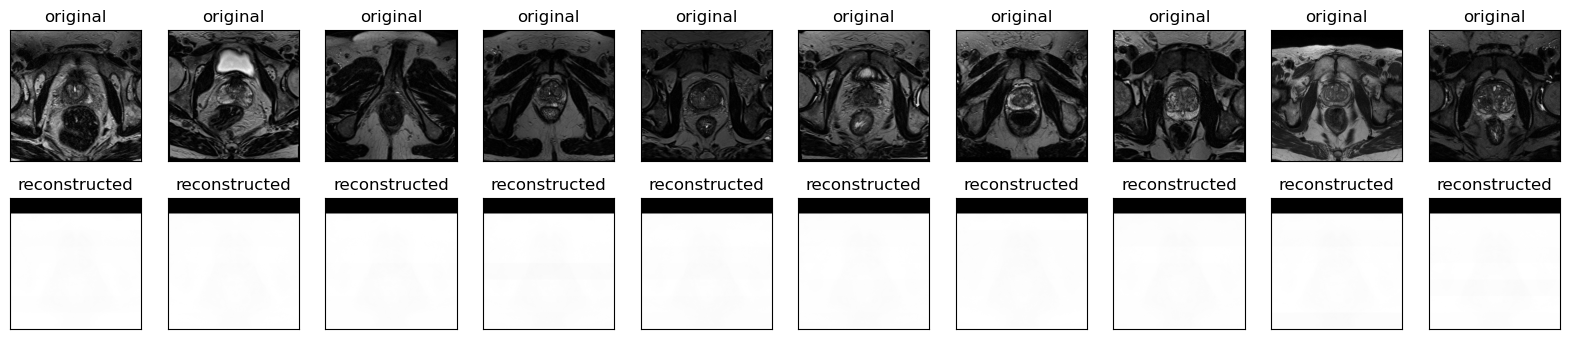

In [19]:
import matplotlib.pyplot as plt

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(images_test_tensor[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
latent_representations = autoencoder.predict(x_test)  # Generate latent representations

# Save the latent representations
np.save('latent_representations.npy', latent_representations)


In [ ]:
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape
from tensorflow.keras.models import Model

# Load latent representations
latent_representations = np.load('latent_representations.npy')

# Define a new model that uses the latent representations
input_latent = Input(shape=(32,))
x = Dense(64, activation='relu')(input_latent)
output = Dense(10, activation='softmax')(x)  # Assuming a classification task with 10 classes
model = Model(input_latent, output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# You would then train this model using the latent representations and your target labels
